# Quantum Neural Networks

In this block we:

    * ...briefly review the neural networks
    * ...explore the quantum neural networks in qiskit

***

# Time for Quantum Neural Networks

... let us explore the quantum neural networks in qiskit.


In [1]:
# Import numpy & usual libraries, check the qiskit version etc.
import numpy as np

# Import basic object from the Qiskit
from qiskit import QuantumCircuit
from qiskit import Aer,BasicAer
from qiskit import execute

# We will need these two
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.kernels import QuantumKernel

# Load account from the disk
from qiskit import IBMQ
IBMQ.load_account() 

# We will need this for plots
from qiskit.visualization import plot_histogram,plot_bloch_multivector

In [2]:
# Check the version of the qiskit you use

# Compared to previous class, I have installed the up-to-date version
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

In [3]:
# Ideal simulator
simulator = Aer.get_backend('qasm_simulator')

# Real-like simulator
from qiskit.providers.aer.noise import NoiseModel

# Choose a particuler quantum computer 
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_belem')

# We derive the noise model from the chosen quantum computer
noise_model = NoiseModel.from_backend(backend)

# Further, we assume the specific qauntum computer:
# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# define backend (simulator)
backendSim = QuantumInstance(
    BasicAer.get_backend("qasm_simulator"), shots=1024
)

# define backend (simulator with specific noise)
backendSimWithNoise = QuantumInstance(
    Aer.get_backend("qasm_simulator"), 
    coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model,
                shots=1024
)

ibmqfactory.load_account:WARNING:2022-03-21 21:11:00,833: Credentials are already in use. The existing account in the session will be replaced.


## Classification using QNN

* We start with classification problem.

* We use implemented library.




Text(0.5, 0, 'x #0')

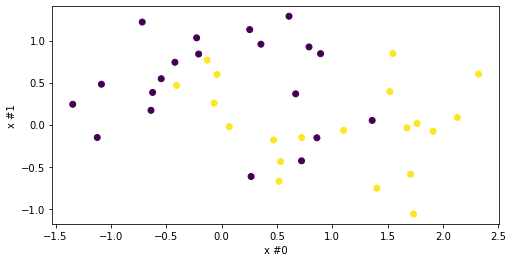

In [4]:
# Prepare random data, using moons
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split


X, y = make_moons(n_samples=40, noise=0.3, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)


fig, ax = plt.subplots(figsize=(8, 4))

ax.scatter(X[:, 0], X[:, 1], c=y)
ax.set_ylabel("x #1")
ax.set_xlabel("x #0")


In [5]:
# We use implemented function from the qiskit library
from qiskit_machine_learning.neural_networks import TwoLayerQNN

# define the two-layer QNN
qnn = TwoLayerQNN(X.shape[1], quantum_instance=backendSim)

## Under the hood...

The TwoLayerQNN -- Two Layer Quantum Neural Network consists of:

* Feature map
* Ansatz
* Observable

Let us explore it in more details

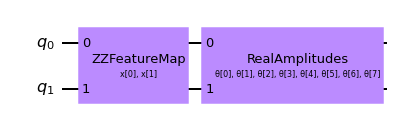

In [6]:
# The 2-layer qnn is an object, we exploire its content

# Drawing the circuit
qnn.circuit.draw(output='mpl')

## Ferature map

We know this element very well, we have explored this in more details already.

The default is ZZFeatureMap, we redefine the feature map using feature_map=

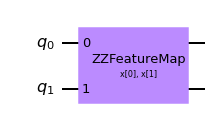

In [7]:
qnn.feature_map.draw(output='mpl')

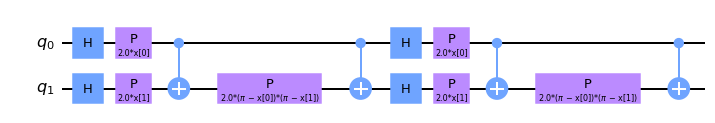

In [8]:
# View in terms of elementary objects...
qnn.feature_map.decompose().draw(output='mpl')

## The Ansatz

The second element of the Neural Network is Ansatz, let explore what this stands for:

In [9]:
# One way to visualise the circuit
print(qnn.ansatz)

     ┌──────────────────────────────────────────────────────────┐
q_0: ┤0                                                         ├
     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7]) │
q_1: ┤1                                                         ├
     └──────────────────────────────────────────────────────────┘


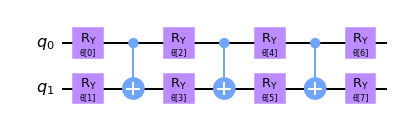

In [10]:
# View in terms of elementary objects...
qnn.ansatz.decompose().draw(output='mpl')

In [11]:
# Finally, we explore the observable element
qnn.observable

PauliSumOp(SparsePauliOp(['ZZ'],
              coeffs=[1.+0.j]), coeff=1.0)

First, we explore the Ansatz:

## Real Amplitudes

The RealAmplitude is a heuristic trial wave function. This is used across different amplications and aims to mix the qubits. 

The circuit is composed of layers of Y-rotation and control nots (entanglement).

Let us explore this circuit on its own:



In [12]:
from qiskit.circuit.library import RealAmplitudes 
ansatz = RealAmplitudes(num_qubits=3, reps=2,insert_barriers=True)

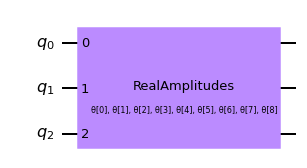

In [13]:
ansatz.draw(output='mpl')

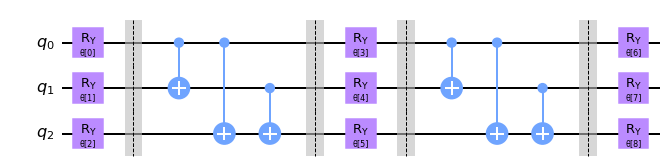

In [14]:
ansatz.decompose().draw(output='mpl')

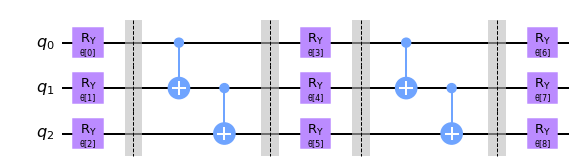

In [15]:
ansatz = RealAmplitudes(num_qubits=3, reps=2,insert_barriers=True, entanglement='linear')
ansatz.decompose().draw(output='mpl')

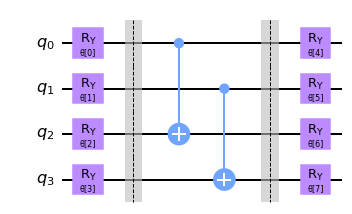

In [16]:
# We can fine-tune the entanglement
ansatz = RealAmplitudes(num_qubits=4, reps=1,insert_barriers=True, entanglement=[[0,2],[1,3]])
ansatz.decompose().draw(output='mpl')

We can specify the topology of our quantum circuit. If our intention is to create the intertwined "network", which resembles the neural network, the RealAmplitudes class is suitable.  



In [17]:
ansatz.ordered_parameters

[ParameterVectorElement(θ[0]),
 ParameterVectorElement(θ[1]),
 ParameterVectorElement(θ[2]),
 ParameterVectorElement(θ[3]),
 ParameterVectorElement(θ[4]),
 ParameterVectorElement(θ[5]),
 ParameterVectorElement(θ[6]),
 ParameterVectorElement(θ[7])]

We will be finding the parameters during the optimisation procedure...



## Observable

The last element is observable.


In [18]:
# Finally, we explore the observable element
qnn.observable

PauliSumOp(SparsePauliOp(['ZZ'],
              coeffs=[1.+0.j]), coeff=1.0)

PauliSumOp -- sum of Pauli operators ('ZZ') with real valued coef 1+0j, multiplied by 1 at the end. 


# Constructing the Estimating Workflow



In [19]:
# define the two-layer QNN -- regenerating it again
qnn = TwoLayerQNN(X.shape[1], quantum_instance=backendSim)

In [20]:
# We can extract some important parameters
qnn.num_inputs

2

In [21]:
qnn.num_weights

8

In [22]:
# We use another elements of the qiskit utility library (generate random weights)
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 42

In [23]:
# We can use any other way to generate random numbers
algorithm_globals.random.random(qnn.num_weights)

array([0.77395605, 0.43887844, 0.85859792, 0.69736803, 0.09417735,
       0.97562235, 0.7611397 , 0.78606431])

In [24]:
random_weights=algorithm_globals.random.random(qnn.num_weights)

In order to calibrate the model, we need to be able to perform a forward pass (evaluate data point(s)) and then pass the data back.

In [25]:
# We pass real data through
X_train[0,:]

array([ 1.70860042, -0.59003473])

In [26]:
qnn.forward(X_train[0,:],random_weights)

array([[0.05273437]])

In [27]:
# We can pass batch of data
qnn.forward(X_train[:2,:],random_weights)

array([[0.06445312],
       [0.24023438]])

In [28]:
qnn.backward(X_train[0,:], random_weights)

(None,
 array([[[-0.10253906,  0.24804688,  0.0078125 ,  0.68554688,
          -0.10351562,  0.3671875 , -0.20996094,  0.51464844]]]))

In [29]:
# ... and original weights coming in as an input
random_weights

array([0.12811363, 0.45038594, 0.37079802, 0.92676499, 0.64386512,
       0.82276161, 0.4434142 , 0.22723872])

### ... towards the learning

We have forward and backward passes.

If we add an optimiser, we can iterate the passes through the data to minimise a specified loss function (we use implemented options as much as possible).

When building neural netwroks in keras, we can add callback function, which manages iteration process (we can add annealing, stop rules etc). The qiskit implementation of the NN classifier (regression) allows us to add the callback function as well.


In [30]:
from IPython.display import clear_output

# we use template one which plots the iteration process.
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    # This needs to be created outside !
    objective_func_vals.append(obj_func_eval)
    plt.title("Optimisation process")
    plt.xlabel("Iteration No")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [31]:
# We need to construct the classifier from the elements we have
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier

# We need optimiser functions, we will use two implemented 
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

qnnClassifier = NeuralNetworkClassifier(qnn, optimizer=COBYLA(), callback=callback_graph)

### Optimisers

* L_BFGS_B -- Limited-memory BFGS Bound optimizer.

* COBYLA -- Constrained Optimization By Linear Approximation optimizer.

* ADAM -- Adam and AMSGRAD optimizers.

* SciPyOptimizer -- A general Qiskit Optimizer wrapping scipy.optimize.minimize.

... among others

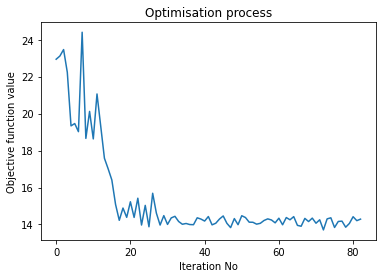

In [32]:
# empty object for the callback function
objective_func_vals = []

# Figure
fig, ax = plt.subplots(figsize=(8, 4))

# fit 
qnnClassifier.fit(X_train, y_train)


In [33]:
qnnClassifier.score(X, y)

0.35

With different optimiser...

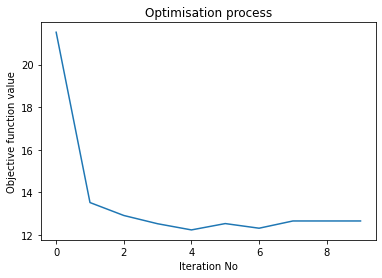

0.4

In [34]:
qnnClassifier2 = NeuralNetworkClassifier(qnn, optimizer=L_BFGS_B(), callback=callback_graph)
# empty object for the callback function
objective_func_vals = []

# Figure
fig, ax = plt.subplots(figsize=(8, 4))

# fit 
qnnClassifier2.fit(X_train, y_train)
qnnClassifier2.score(X, y)

In [35]:
# Out of sample prediction
y_predict = qnnClassifier2.predict(X_test)

# Out of sample score
qnnClassifier2.score(X_test, y_test)


0.4

We can run number of numerical exercises, we can create our own network topology

TwoLayerQNN has these default values, we can override them

* feature_map=None,

* ansatz=None,
    * This may be off interest for driving the depth of the network

* observable=None


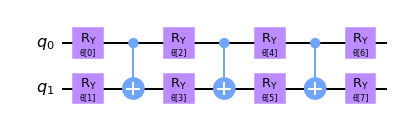

In [36]:
# We can fine-tune the entanglement
ansatzQnn = RealAmplitudes(num_qubits=X.shape[1], reps=3)
ansatzQnn.decompose().draw(output='mpl')

In [37]:
qnn3 = TwoLayerQNN(X.shape[1], ansatz=ansatzQnn, quantum_instance=backendSim)

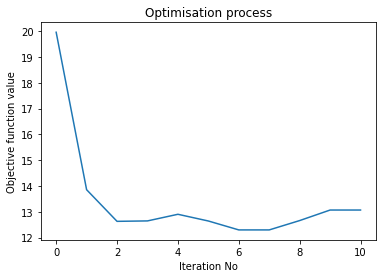

0.375

In [38]:
qnnClassifier3 = NeuralNetworkClassifier(qnn3, optimizer=L_BFGS_B(), callback=callback_graph)
# empty object for the callback function
objective_func_vals = []

# Figure
fig, ax = plt.subplots(figsize=(8, 4))

# fit 
qnnClassifier3.fit(X_train, y_train)
qnnClassifier3.score(X, y)

***
Given we can specify entanglement between different qubits, we can mimic the NN for picture recognition ...
***

***
## Multidimensional input

Let us illustrate multidimensional input.
***

In [39]:
from sklearn.datasets import make_classification
Xx, yx = make_classification(n_samples=40, n_features=4, random_state=0)
Xx_train, Xx_test, yx_train, yx_test = train_test_split(Xx, yx, stratify=yx, random_state=0)



In [40]:
Xx_train[:5,:]

array([[ 0.11132084,  1.61556036,  1.55618371,  0.68424183],
       [-0.47678361, -0.39970521, -1.4703221 ,  1.1488029 ],
       [ 0.31968562,  1.14674592,  1.6860224 , -0.22044629],
       [-0.09468434,  1.24267725,  0.76139696,  1.05535409],
       [-0.0756485 ,  1.02156095,  0.63120374,  0.86114912]])

QiskitMachineLearningError: 'Input data has incorrect shape, last dimension is not equal to the number of inputs: 2, but got: 4.'

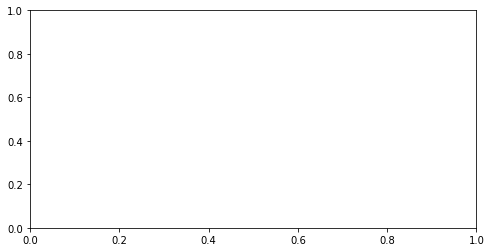

In [41]:
qnn4 = TwoLayerQNN(X.shape[1],  quantum_instance=backendSim)

qnnClassifier4 = NeuralNetworkClassifier(qnn4, optimizer=L_BFGS_B(), callback=callback_graph)
# empty object for the callback function
objective_func_vals = []

# Figure
fig, ax = plt.subplots(figsize=(8, 4))

# fit 
qnnClassifier4.fit(Xx_train, yx_train)
qnnClassifier4.score(Xx_train, yx_train)


## Another way to construct QNN

We can create a QNN from a parametrised quantum circuit (circuit with operations on qubits, parametrised). The circuit is used to generate samples and the QNN is assessed. 

This framework requires from user to generate the circuit. 

The difference is in the last component -- observable. We do not specify it here, but we specify in the qnn wrapper how we interpret outcome.


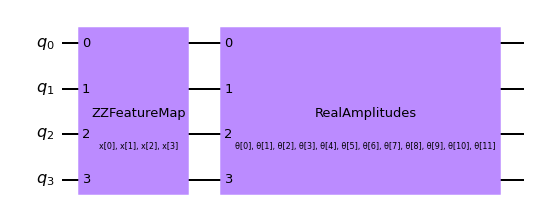

In [42]:
# Define Feature map, Pauli-Z evolution circuit 
from qiskit.circuit.library import ZZFeatureMap

featureMap= ZZFeatureMap(Xx_train.shape[1])

# Circuit -- we ise Real Amplitudes again
ansatz = RealAmplitudes(Xx_train.shape[1], reps=2)

# Import basic object from the Qiskit
from qiskit import QuantumCircuit

qc = QuantumCircuit(Xx_train.shape[1])
qc.append(featureMap, range(Xx_train.shape[1]))
qc.append(ansatz, range(Xx_train.shape[1]))
qc.decompose().draw(output="mpl")

In [43]:
# We need to interpret the outcome (array of 0's and 1's for classification -> we define a probability to measure "1")

def parity(x):
    return "{:b}".format(x).count("1") % 2

In [44]:
from qiskit_machine_learning.neural_networks import CircuitQNN

# We define the qnn based on the circuit
qnnCircuit = CircuitQNN(
    circuit=qc,
    input_params=featureMap.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=2,
    quantum_instance=simulator,
)

In [45]:
# We need to wrap the circuit into a classifier, using the same callback function

qnnCircuitClassifier = NeuralNetworkClassifier(
    neural_network=qnnCircuit, optimizer=COBYLA(), callback=callback_graph
)

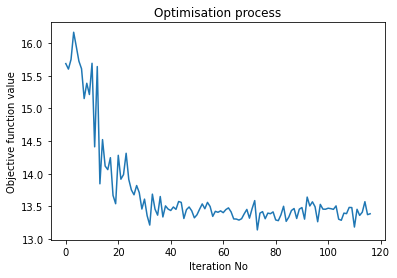

0.7

In [46]:
# empty object for the callback function
objective_func_vals = []

# Figure
fig, ax = plt.subplots(figsize=(8, 4))

# fit 
qnnCircuitClassifier.fit(Xx_train, yx_train)
qnnCircuitClassifier.score(Xx_train, yx_train)

In [47]:
# Out of sample evaluation
qnnCircuitClassifier.score(Xx_test, yx_test)

0.5

***
What if we have classification with d-classes?
***

In [48]:
X3, y3 = make_classification(n_samples=40, n_features=4,n_clusters_per_class=1, n_classes=3,random_state=0)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, stratify=y3, random_state=0)



In [49]:
X3_train[:5,:]

array([[-0.07655627,  0.95270767,  0.57414971,  0.82073083],
       [ 0.31929269, -0.01251403,  0.76139696, -0.94464591],
       [-0.15169212,  1.12470757,  0.5296779 ,  1.1488029 ],
       [ 0.33832854, -0.23363032,  0.63120374, -1.13885088],
       [ 0.05230424,  1.55432435,  1.36481591,  0.81908303]])

In [50]:
y3_train[:10]

array([1, 2, 1, 2, 1, 1, 0, 2, 1, 2])

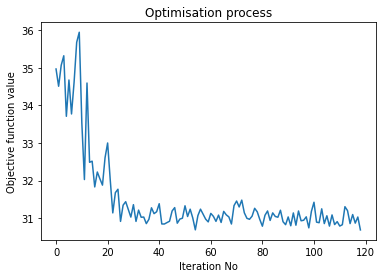

0.43333333333333335

In [51]:
featureMap3= ZZFeatureMap(X3_train.shape[1])

# Circuit -- we ise Real Amplitudes again
ansatz3 = RealAmplitudes(X3_train.shape[1], reps=2)

qc3 = QuantumCircuit(X3_train.shape[1])
qc3.append(featureMap3, range(X3_train.shape[1]))
qc3.append(ansatz3, range(X3_train.shape[1]))
qc3.decompose().draw(output="mpl")

qnnCircuit3 = CircuitQNN(
    circuit=qc3,
    input_params=featureMap3.parameters,
    weight_params=ansatz3.parameters,
    interpret=parity,
    output_shape=3,
    quantum_instance=simulator,
)

qnnCircuitClassifier3 = NeuralNetworkClassifier(
    neural_network=qnnCircuit3, optimizer=COBYLA(), callback=callback_graph
)

# empty object for the callback function
objective_func_vals = []

# Figure
fig, ax = plt.subplots(figsize=(8, 4))

# fit 
qnnCircuitClassifier3.fit(X3_train, y3_train)
qnnCircuitClassifier3.score(X3_train, y3_train)

In [52]:
# Predict
qnnCircuitClassifier3.predict(X3_train)

array([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0])

***
The shape is not enough, we need to extend parity to multiple classes. What is the form?

Alternatively, we can use another function, Variational Quantum Classifier. This allows us to specify loss function (in the case of multi-class classification, it is cross-entropy).

***

In [53]:
# We need one-hot encoded classes
y3_train_hot = np.zeros((y3_train.shape[0], 3))
for i in range(y3_train.shape[0]):
    y3_train_hot[i, y3_train[i]] = 1
    
# We need one-hot encoded classes
y3_test_hot = np.zeros((y3_test.shape[0], 3))
for i in range(y3_test.shape[0]):
    y3_test_hot[i, y3_test[i]] = 1

In [54]:
y3_train_hot[:5,:]

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [55]:
featureMap4 = ZZFeatureMap(X3_train.shape[1])
ansatz4 = RealAmplitudes(X3_train.shape[1], reps=2)


from qiskit_machine_learning.algorithms.classifiers import  VQC
# construct variational quantum classifier
vqc = VQC(
    feature_map=featureMap4,
    ansatz=ansatz4,
    loss="cross_entropy",
    optimizer=COBYLA(),
    quantum_instance=simulator,
    callback=callback_graph,
)

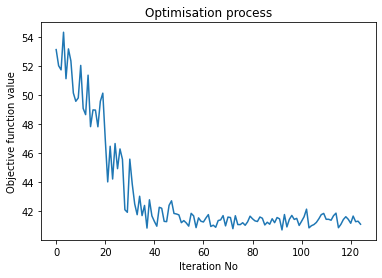

0.4666666666666667

In [56]:
# empty array
objective_func_vals = []

# fit 
vqc.fit(X3_train, y3_train_hot)

# score classifier
vqc.score(X3_train, y3_train_hot)

In [57]:
# prediction has the correct shape
vqc.predict(X3_test)

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

***
# Regressions

Let us progress with regression problem. 

We use regression analogue to Variational Quantum Classifier -- Variational Quantum Regressor. 

We will use the data we have employed for kernel ridge.

***

In [58]:
rng = np.random.RandomState(0)

# Generate sample data, smaller
X = 5 * rng.rand(50, 1)
y = np.sin(X).ravel()
noise = np.random.normal(0,0.1,50)

y=y+noise
# Add noise to targets
#y[::5] += 1 * (0.5 - rng.rand(X.shape[0] // 5))

X_plot = np.linspace(0, 5, 50)[:, None]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

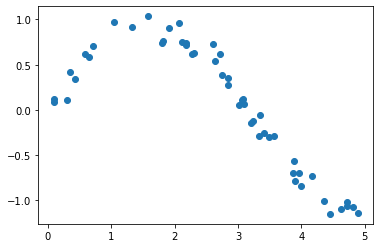

In [59]:
# Plot the data
plt.scatter(X, y, label = "Kernel Ridge data -- smaller draw")

# Display a figure.
plt.show()

In [60]:
from qiskit_machine_learning.algorithms.regressors import  VQR

In [61]:
featureMap5 = ZZFeatureMap(X_train.shape[1])
ansatz5 = RealAmplitudes(X_train.shape[1], reps=2)

vqr = VQR(
    feature_map=featureMap5,
    ansatz=ansatz5,
    optimizer=L_BFGS_B(),
    quantum_instance=simulator,
    callback=callback_graph,
)

ValueError: The ZZFeatureMap contains 2-local interactions and cannot be defined for less than 2 qubits. You provided 1.

In [62]:
from qiskit.circuit import Parameter

# We need to define single-qubit feature map
paramX = Parameter("x")
featureMapSingle = QuantumCircuit(1, name="featureMap")
featureMapSingle.ry(paramX, 0)

# ...and ansatz
paramY = Parameter("y")
ansatzSingle = QuantumCircuit(1, name="ansatz")
ansatzSingle.ry(paramY, 0)

vqr = VQR(
    feature_map=featureMapSingle,
    ansatz=ansatzSingle,
    optimizer=L_BFGS_B(),
    quantum_instance=simulator,
    callback=callback_graph,
)

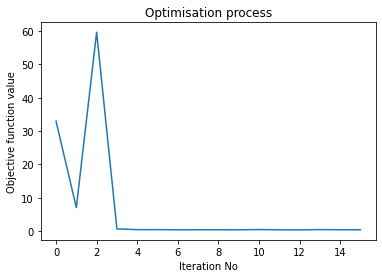

0.973237252725365

In [63]:
# empty array
objective_func_vals = []

# fit 
vqr.fit(X_train, y_train)

# score result
vqr.score(X_train, y_train)

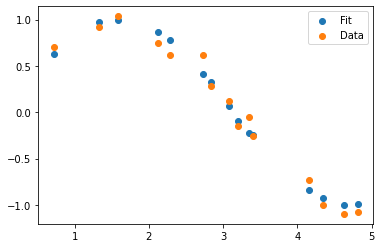

In [64]:
# predict
y_predict = vqr.predict(X_test)

# plot 
plt.scatter(X_test.ravel(), y_predict.ravel(),label="Fit")

# plot 
plt.scatter(X_test.ravel(), y_test.ravel(),label="Data")
plt.legend()

plt.show()

In [65]:
# score result
vqr.score(X_test, y_test)

0.9843749576580635

***

We have explored another quantum-enhanced method for classification and regression.

The kernel is not the only quantum enhancement, we vary a circuit itself.

***